In [ ]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


### Downloading Data from Kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/My Drive/Kaggle"
MAIN_DIR = "/content/drive/My Drive/Kaggle"
os.chdir(MAIN_DIR)

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification
!unzip /content/drive/MyDrive/Kaggle/cassava-leaf-disease-classification.zip

### Importing Models, Files, and Exploratory Data Analysis

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
from PIL import Image
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# this API can improve performance by more than 
# 3 times on modern GPUs and 60% on TPUs
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

AUTOTUNE = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [ ]:
DATA_DIR = "/content/drive/My Drive/Kaggle"
TRAIN_DIR = "/content/drive/My Drive/Kaggle/train_images"
TEST_DIR = "/content/drive/My Drive/Kaggle/test_images"
os.chdir(DATA_DIR)

In [ ]:
len_test_data = len(os.listdir(TEST_DIR))
len_train_data = len(os.listdir(TRAIN_DIR))
print (f"Len. Test Data: {len_test_data}, \nLen. Train Data: {len_train_data}")

Len. Test Data: 1, 
Len. Train Data: 21397


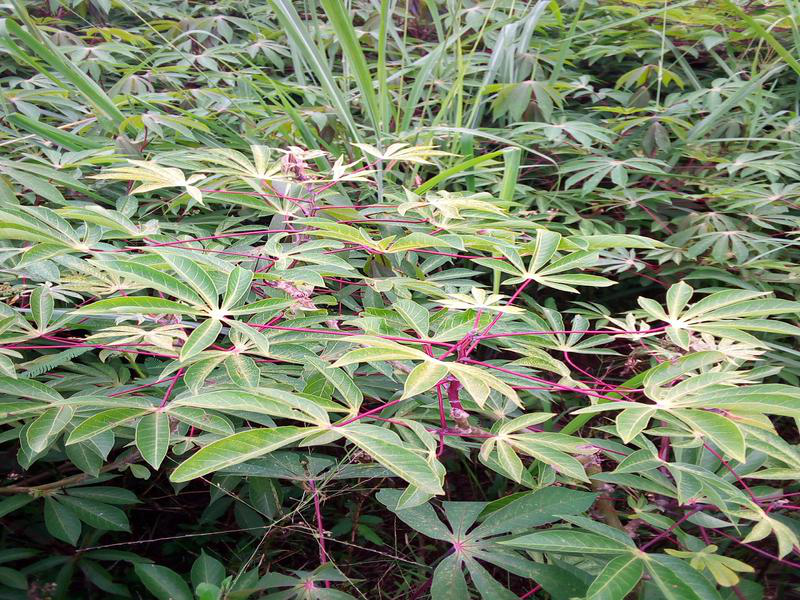

In [ ]:
Image.open(os.path.join(TEST_DIR, os.listdir(TEST_DIR)[0]))

In [ ]:
train_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_data.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [ ]:
train_data["filepath"] = TRAIN_DIR +"/"+ train_data["image_id"]
train_data.head()

image_id  label                                           filepath
0  1000015157.jpg      0  /content/drive/My Drive/Kaggle/train_images/10...
1  1000201771.jpg      3  /content/drive/My Drive/Kaggle/train_images/10...
2   100042118.jpg      1  /content/drive/My Drive/Kaggle/train_images/10...
3  1000723321.jpg      1  /content/drive/My Drive/Kaggle/train_images/10...
4  1000812911.jpg      3  /content/drive/My Drive/Kaggle/train_images/10...

In [ ]:
train_data.isnull().sum()

image_id    0
label       0
dtype: int64

###### ETL

In [ ]:
train_data.dtypes

image_id    object
label        int64
dtype: object

In [ ]:
#Check the number of classes
count_obsv = train_data.label.value_counts().reset_index()
count_obsv.columns=["labels", "No. of Obsv."]
count_obsv

labels  No. of Obsv.
0       3         13158
1       4          2577
2       2          2386
3       1          2189
4       0          1087

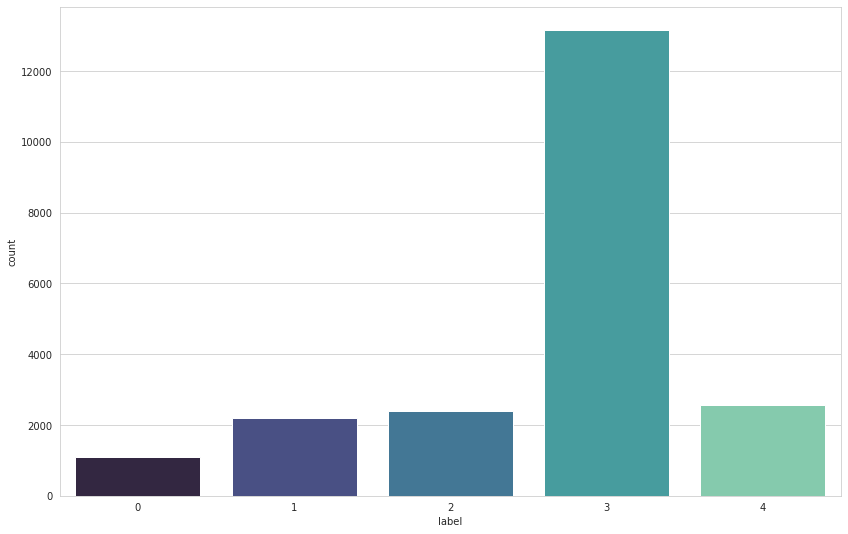

In [ ]:
# Problem with class imbalance
sns.set_style("whitegrid")
plt.figure(figsize=(14, 9))
sns.countplot(train_data['label'], palette='mako')

In [ ]:
# Load the images by classes
def load_imgs(imgs):

    plt.figure(figsize=(25, 13))
    index = 0
    for i in imgs:
        img = Image.open(os.path.join(TRAIN_DIR, i))
        plt.subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.axis("off")
        index+=1
    plt.show()        

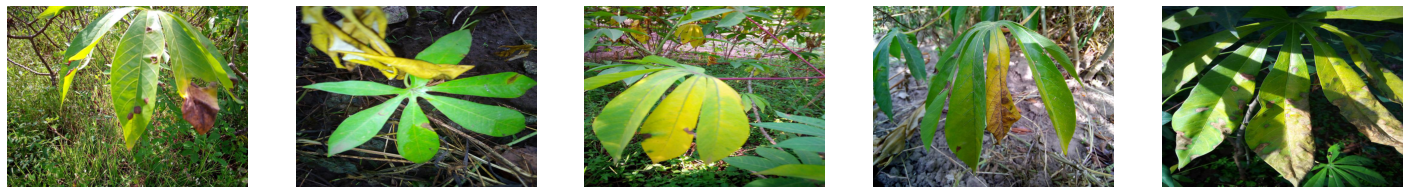

In [ ]:
# Class 0
class_0 = train_data[train_data['label'] == 0]
class_0_img = class_0['image_id'].sample(5).tolist()
load_imgs(class_0_img)

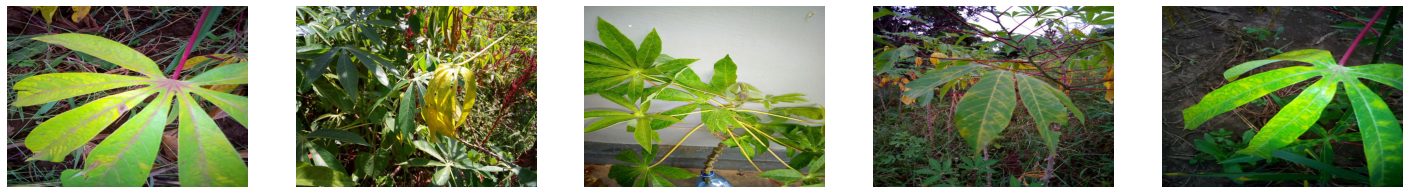

In [ ]:
# Class 1
class_1 = train_data[train_data['label'] == 1]
class_1_img = class_1['image_id'].sample(5).tolist()
load_imgs(class_1_img)

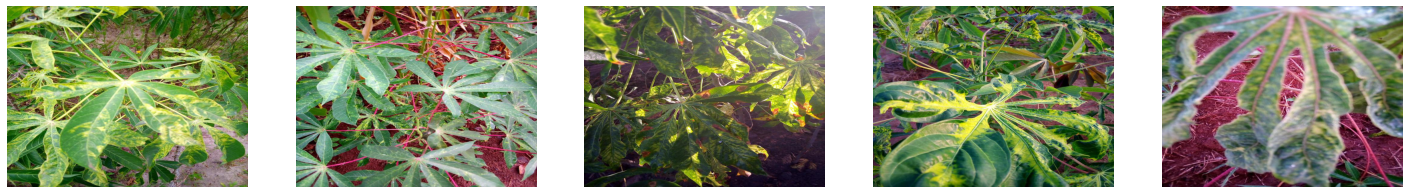

In [ ]:
# Class 3
class_3 = train_data[train_data['label'] == 3]
class_3_img = class_3['image_id'].sample(5).tolist()
load_imgs(class_3_img)

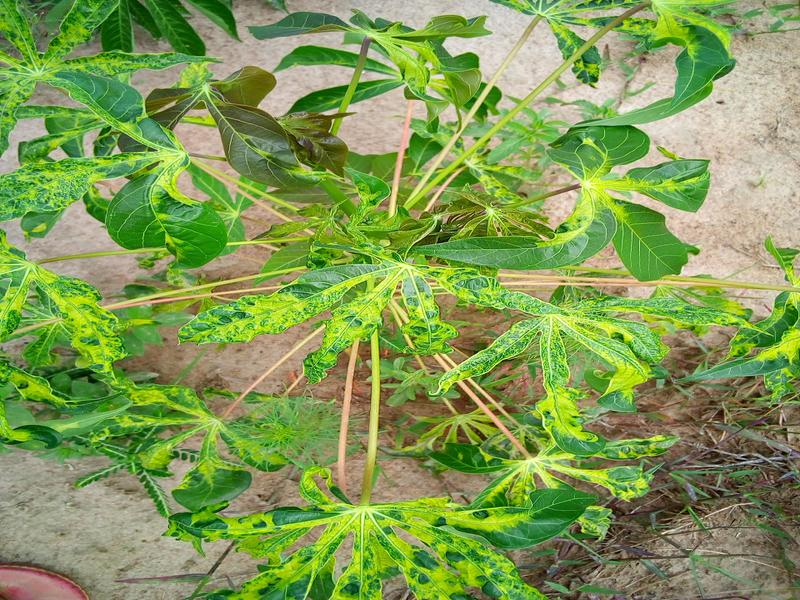

In [ ]:
img_name = random.choice(os.listdir(TRAIN_DIR))
img = os.path.join(TRAIN_DIR, img_name)
img = cv2.imread(img)
cv2_imshow(img)

In [ ]:
img.shape

(600, 800, 3)

In [ ]:
# Dealing with imbalance classes
# Undersampling
# Oversampling
# Adjusting the loss function and penalize mistakes on rare classes more
# Give higher weights to minority classes
# Data Augmentation (Albumentation)
# Synthetic Minority Over-sampling Technique (SMOTE)
# Change Confusion Matrix performance
# GAN using Deep Learning for images
# Style transfer
# Learning rate scheduler
# 


###### Data Augmentation and Creating Tensorflow Datasets

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from functools import partial
import gc

In [ ]:
#Using StratifiedKFold will also help in the class imbalance
skf = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.3,
    random_state=42
)
for train_idx, val_idx in skf.split(train_data["image_id"], train_data["label"]):
    train_df = train_data.loc[train_idx]
    val_df = train_data.loc[val_idx]

In [ ]:
def load_img_and_label(img_path, label):
    # Convert the image to a tf.tensor
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

# Create tensorflow datasets from dataframe
gen_train = tf.data.Dataset.from_tensor_slices(
    (train_df["filepath"].values,
     train_df["label"].values)
)

gen_val = tf.data.Dataset.from_tensor_slices(
    (val_df["filepath"].values,
     val_df["label"].values)
)

gen_train = gen_train.map(load_img_and_label, num_parallel_calls=AUTOTUNE)
gen_val = gen_val.map(load_img_and_label, num_parallel_calls=AUTOTUNE)

In [ ]:
# Data augmentation with albumentation
import albumentations as A

BATCH_SIZE = 32
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Augment train data with albumentation
def train_augmentation(train_dataset):
    train_transforms = A.Compose(
        transforms=[
            #A.Rotate(limit=40),
            A.JpegCompression(
                quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=20, sat_shift_limit=30,
                val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=1),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5),
            A.Cutout(p=0.5),
        ], p=1
    )

    def aug_fn(image):
        data = {"image":image}
        aug_data = train_transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(
            func=aug_fn, inp=[image], Tout=tf.float32
        )
        return aug_img, label

    def set_shapes(img, label, img_shape=input_shape):
        img.set_shape(img_shape)
        label.set_shape([])
        return img, label

    ds_alb = train_dataset.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE)
    ds_alb = ds_alb.repeat()
    ds_alb = ds_alb.batch(BATCH_SIZE)

    return ds_alb


In [ ]:
# Augment val data with albumentation
def val_augmentation(val_dataset):
    # leave validation sets unchanged
    val_transforms = A.Compose(
        transforms=[
            A.CenterCrop(IMAGE_SIZE,IMAGE_SIZE)
        ],
        p=1
    )

    def aug_fn(image):
        data = {"image":image}
        aug_data = val_transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(
            func=aug_fn, inp=[image], Tout=tf.float32
        )
        return aug_img, label

    def set_shapes(img, label, img_shape=input_shape):
        img.set_shape(img_shape)
        label.set_shape([])
        return img, label

    ds_alb = val_dataset.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE)
    ds_alb = ds_alb.batch(BATCH_SIZE)
    return ds_alb


In [ ]:
train_dlb = train_augmentation(gen_train)
val_dlb = val_augmentation(gen_val)

In [ ]:
train_dlb

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
def view_img(datasets_):
    img, label = next(iter(datasets_))  #Extract 1 batch from the dataset
    img = img.numpy()/255
    label = label.numpy()

    fig = plt.figure(figsize=(25, 25))
    for i in range(16):
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        ax.imshow(img[i])
        ax.set_title(f"Label: {label[i]}")

In [ ]:
view_img(train_dlb)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_img(val_dlb)

Output hidden; open in https://colab.research.google.com to view.

#### Build Model and Training

In [ ]:
## I dealt with the imbalanced in the dataset in two ways:
## First, augument the data to produce more datapoints for each classe
## Second, implement label smoothing on our loss metrics. i.e cross entropy loss
## 

In [ ]:
# Tensor board
%load_ext tensorboard

# Tensorflow and Keras
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Activation, Input, GlobalAveragePooling2D)
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Build custom train_val_split for the dataset
def train_val_split(train, val):
    
    def load_img_and_label(img_path, label):
        #Convert the image to a tf.tensor
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        return img, label

    gen_train = tf.data.Dataset.from_tensor_slices(
        (train["filepath"].values,
        train["label"].values)
    )

    gen_val = tf.data.Dataset.from_tensor_slices(
        (val["filepath"].values,
        val["label"].values)
    )

    gen_train = gen_train.map(load_img_and_label, num_parallel_calls=AUTOTUNE)
    gen_val = gen_val.map(load_img_and_label, num_parallel_calls=AUTOTUNE)

    return (gen_train, gen_val)

In [ ]:
PRECISION = tf.keras.metrics.Precision()
RECALL = tf.keras.metrics.Recall()

#Building custom F1_score metrics, due to the imbalance dataset
def F1_score(y_true, y_pred):
    
    PRECISION.reset_states()
    RECALL.reset_states()

    precision_out = PRECISION.update_state(y_true, y_pred)
    precision_out = PRECISION.result()

    recall_out = RECALL.update_state(y_true, y_pred)
    recall_out = RECALL.result()

    return 2 * ((precision_out*recall_out)/(precision_out+recall_out+1e-23))

In [ ]:
#from tensorflow.python.ops.gen_array_ops import shape
def create_inception():

    base_model = InceptionV3(
        include_top=False, weights="imagenet", input_shape=input_shape)
    
    # Build top with functional API
    inputs = Input(shape=input_shape)
    model = base_model(inputs)
    pooling = GlobalAveragePooling2D()(model)
    dropout = Dropout(0.2)(pooling)

    outputs = Dense(
        5, activation="softmax", name="dense",
        dtype="float32")(dropout)

    # Compile the model
    inception = Model(inputs=inputs, outputs=outputs)
    optimizer = tfa.optimizers.RectifiedAdam()
    loss = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.2, from_logits=True
    ),
    inception.compile(
        optimizer=optimizer, loss=loss, metrics=["accuracy", F1_score]
    )

    return inception

In [ ]:
def create_mobilenet():
    base_model = MobileNet(
        include_top=False, weights=None, input_shape=input_shape, pooling="max")
    
    inputs = Input(shape=input_shape)
    model = base_model(inputs)
    dropout = Dropout(0.5)(model)
    outputs = Dense(
        5, activation="softmax", name="dense", dtype="float32")(dropout)

    # compile model
    mobilenet = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.02, momentum=0.9, nesterov=True)
    loss = tf.keras.CategoricalCrossentropy(
        label_smoothing=0.3, from_logits=True)
    
    mobilenet.compile(
        optimizer=optimizer, loss=loss, metrics=["accuracy", F1_score]
    )

    return mobilenet

In [ ]:
EPOCHS = 20
STEPS = int(len(train_data)*0.8/BATCH_SIZE)+1
FOLD_NUM = 4 #len of train_lst or val_lst
N_SPLITS = 5
train_lst = [] #list of different stratified split of dataframe
val_lst = []


skf = StratifiedKFold(  #Instead of StratifiedKFold use StratifiedShuffleSplit since you;re still picking on major split
    n_splits=N_SPLITS, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(train_data["image_id"], train_data["label"]):
    train_lst.append(train_idx)
    val_lst.append(val_idx)

In [ ]:
import datetime
logdir = os.path.join("/content/inception/log_dir", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

for i in range(N_SPLITS - FOLD_NUM):  #Pick a fold number
    tf.keras.backend.clear_session()
    gc.collect()
    train_set = train_data.loc[train_lst[FOLD_NUM]] #A strtified df of the train set
    val_set = train_data.loc[val_lst[FOLD_NUM]] #Stratified df of val set
    skf_train, skf_val = train_val_split(train_set, val_set)
    train_aug = train_augmentation(skf_train)
    val_aug = val_augmentation(skf_val)
    model = create_inception()
    model_name = "CassavaInceptionV3-V2"
    fold_name = "fold.h5"
    model_path = os.path.join(DATA_DIR, model_name + str(FOLD_NUM) + fold_name)
    print (f"Training on fold no,: {str(FOLD_NUM+1)}")
    callbacks = [
        ReduceLROnPlateau(
            monitor="val_loss", patience=2, verbose=1, factor=0.2),
        EarlyStopping(
            monitor="val_loss", patience=3, verbose=1, restore_best_weights=True),
        ModelCheckpoint(
            filepath=model_path, monitor="val_accuracy", save_best_only=True),
        #TensorBoard(
        #    log_dir = logdir, histogram_freq = 1, update_freq="epoch")
    ]
    history = model.fit(
        train_aug, steps_per_epoch=STEPS, epochs=EPOCHS,
        validation_data=val_aug, callbacks=callbacks)
    
    FOLD_NUM += 1
    if FOLD_NUM == N_SPLITS:
        print("Training finished")
    
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df['root_mean_squared_error'])
plt.xlabel("epochs")
plt.ylabel("RMSE")

In [ ]:
logdir = os.path.join("/content/mobilenet/log_dir", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

for i in range(N_SPLITS - FOLD_NUM):  #Pick a fold number
    tf.keras.backend.clear_session()
    gc.collect()
    train_set = train_data.loc[train_lst[FOLD_NUM]] #A strtified df of the train set
    val_set = train_data.loc[val_lst[FOLD_NUM]] #Stratified df of val set
    skf_train, skf_val = train_val_split(train_set, val_set)
    train_aug = train_augmentation(skf_train)
    val_aug = val_augmentation(skf_val)
    model = create_mobilenetn()
    model_name = "CassavaInceptionV3-V2"
    fold_name = "fold.h5"
    model_path = os.path.join(DATA_DIR, model_name + str(FOLD_NUM) + fold_name)
    print (f"Training on fold no,: {str(FOLD_NUM+1)}")
    callbacks = [
        ReduceLROnPlateau(
            monitor="val_loss", patience=2, verbose=1, factor=0.2),
        EarlyStopping(
            monitor="val_loss", patience=3, verbose=1, restore_best_weights=True),
        ModelCheckpoint(
            filepath=model_path, monitor="val_accuracy", save_best_only=True),
        #TensorBoard(
        #    log_dir = logdir, histogram_freq = 1, update_freq="epoch")
    ]
    history = model.fit(
        train_aug, steps_per_epoch=STEPS, epochs=EPOCHS,
        validation_data=val_aug, callbacks=callbacks)
    
    FOLD_NUM += 1
    if FOLD_NUM == N_SPLITS:
        print("Training finished")
    
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df['root_mean_squared_error'])
plt.xlabel("epochs")
plt.ylabel("RMSE")

In [ ]:
## Inference

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow_addons.optimizers import RectifiedAdam
model_path = os.path.join(DATA_DIR, "CassavaInceptionV34fold.h5")
load_model_ = load_model(
    model_path,
    custom_objects = {"RectifiedAdam": RectifiedAdam})
load_model_.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
____________________________________________

In [ ]:
img = tf.keras.preprocessing.image.load_img(os.path.join(TEST_DIR, os.listdir(TEST_DIR)[0]))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = tf.reshape(img, (-1, IMAGE_SIZE, IMAGE_SIZE, 3))

prediction = load_model_.predict(img/255)

In [ ]:
np.argmax(prediction)

3